In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage

In [2]:
# 1. MOUNT GOOGLE DRIVE
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. SET YOUR PATH (Update 'Your_Folder_Name')
# Example: '/content/drive/MyDrive/PhD_Data/Experiment_1'
INPUT_DIR = '/content/drive/My Drive/849/Capture_Test/After_Break_Emulsion/40kDa_x10'
DEXTRAN_TYPE = "40k"
STATE = "Buffer"

In [ ]:
# 3. DETECTION PARAMETERS (Adjust these!)
MIN_AREA = 4000          # Ignore objects smaller than this (fragments)
CIRCULARITY_LIMIT = 0.7 # 1.0 is a perfect circle. Ignore long/weird shapes.
PEAK_MIN_DIST = 15      # Min pixels between bead centers (helps split touching beads)
SHRINK_FACTOR = 0.85    # Measure GFP at 85% of radius to stay inside the shell

In [ ]:
def run_analysis():
    if not os.path.exists(INPUT_DIR):
        print(f"ERROR: Path not found: {INPUT_DIR}")
        return

    # Case-insensitive search for d0.tif files
    all_files = os.listdir(INPUT_DIR)
    dapi_files = sorted([f for f in all_files if f.lower().endswith('d0.tif')])

    print(f"Total files: {len(all_files)} | DAPI sets found: {len(dapi_files)}")

    results = []

    for filename in dapi_files:
        ext = ".TIF" if filename.endswith(".TIF") else ".tif"
        dapi_path = os.path.join(INPUT_DIR, filename)
        gfp_path = os.path.join(INPUT_DIR, filename.replace(f"d0{ext}", f"d1{ext}"))

        if not os.path.exists(gfp_path):
            continue

        # Load Images
        dapi = cv2.imread(dapi_path, cv2.IMREAD_UNCHANGED)
        gfp = cv2.imread(gfp_path, cv2.IMREAD_UNCHANGED)

        # Normalize DAPI for mask creation
        dapi_8 = cv2.normalize(dapi, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        blur = cv2.GaussianBlur(dapi_8, (5, 5), 0)

        # 1. THRESHOLDING
        _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # 2. WATERSHED (The Bead Splitter)
        # Calculate distance to background
        distance = ndimage.distance_transform_edt(thresh)
        # Find local peaks (the center of each bead)
        local_maxi = peak_local_max(distance, min_distance=PEAK_MIN_DIST, labels=thresh)

        # Create markers for watershed
        markers = np.zeros(distance.shape, dtype=int)
        for idx, peak in enumerate(local_maxi):
            markers[peak[0], peak[1]] = idx + 1

        # Run Watershed
        labels = watershed(-distance, markers, mask=thresh)

        # Setup Visualization
        viz = cv2.cvtColor(dapi_8, cv2.COLOR_GRAY2BGR)
        count = 0

        # 3. ANALYZE EACH DETECTED OBJECT
        for label in np.unique(labels):
            if label == 0: continue # Skip background

            mask_single = np.zeros(thresh.shape, dtype="uint8")
            mask_single[labels == label] = 255

            cnts, _ = cv2.findContours(mask_single, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not cnts: continue

            c = cnts[0]
            area = cv2.contourArea(c)

            # --- FILTERING ---
            if area < MIN_AREA: continue

            perimeter = cv2.arcLength(c, True)
            if perimeter == 0: continue
            circularity = 4 * np.pi * (area / (perimeter * perimeter))
            if circularity < CIRCULARITY_LIMIT: continue

            # Get geometry
            (x, y), radius = cv2.minEnclosingCircle(c)
            center = (int(x), int(y))
            effective_radius = int(radius * SHRINK_FACTOR)

            # 4. MEASURE GFP
            gfp_mask = np.zeros(gfp.shape, dtype=np.uint8)
            cv2.circle(gfp_mask, center, effective_radius, 255, -1)
            mean_intensity = cv2.mean(gfp, mask=gfp_mask)[0]

            results.append({
                'FileName': filename,
                'Intensity': mean_intensity,
                'Radius': effective_radius,
                'Circularity': circularity,
                'Type': DEXTRAN_TYPE,
                'State': STATE
            })

            # Label on DAPI
            cv2.circle(viz, center, effective_radius, (0, 255, 0), 2)
            count += 1

        print(f"Processed {filename}: Identified {count} valid HHBs")
        cv2_imshow(viz)

        # Save Labeled Image to Drive
        save_name = filename.replace(f"d0{ext}", f"_Watershed_Labeled{ext}")
        cv2.imwrite(os.path.join(INPUT_DIR, save_name), viz)

   # 5. EXPORT CSV
    if results:
        df = pd.DataFrame(results)
        # CHANGE: This path saves it directly into your Drive folder
        csv_path = os.path.join(INPUT_DIR, f"Results_{DEXTRAN_TYPE}_{STATE}.csv")
        df.to_csv(csv_path, index=False)
        print(f"✅ DONE! CSV saved to Drive at: {csv_path}")
    else:
        print("❌ No HHBs matched your size/circularity criteria.")

run_analysis()

Output hidden; open in https://colab.research.google.com to view.

# **Draw figure**

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# 1. Provide the direct paths to your 4 CSV files
df40_oil  = pd.read_csv('/content/drive/MyDrive/849/Capture_Test/40kDa_in_oil_x10/Results_40k_Oil.csv')
df40_buf  = pd.read_csv('/content/drive/MyDrive/849/Capture_Test/After_Break_Emulsion/40kDa_x10/Results_40k_Buffer.csv')
df2000_oil = pd.read_csv('/content/drive/MyDrive/849/Capture_Test/2000kDa_in_oil_x10/Results_2000k_Oil.csv')
df2000_buf = pd.read_csv('/content/drive/MyDrive/849/Capture_Test/After_Break_Emulsion/2000kDa_x10/Results_2000k_Buffer.csv')

/tmp/ipython-input-4186861413.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=all_data, x='Type', y='Intensity', hue='State', ci='sd', capsize=.1, palette='muted')


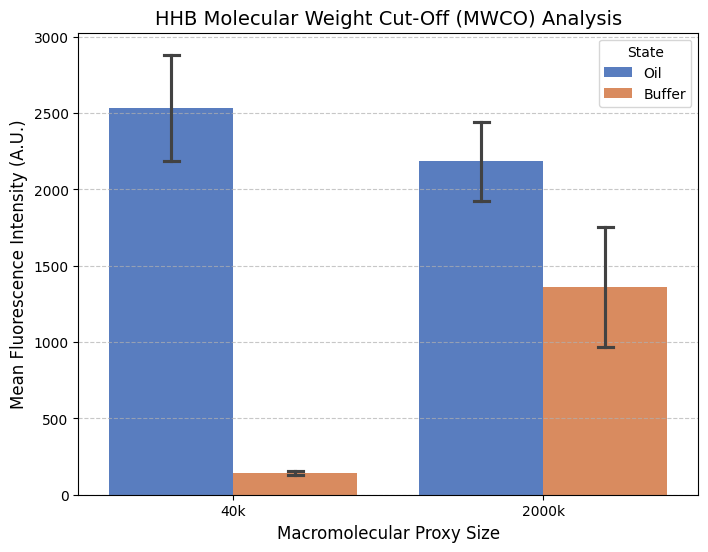

Figure saved to: /content/drive/MyDrive/849/Capture_Test/HHB_bar_Plot.png


In [ ]:
# 2. Combine them
all_data = pd.concat([df40_oil, df40_buf, df2000_oil, df2000_buf])

# 3. Plotting
plt.figure(figsize=(8, 6))
# 'hue' splits the bars into Oil and Buffer
sns.barplot(data=all_data, x='Type', y='Intensity', hue='State', ci='sd', capsize=.1, palette='muted')

plt.title('HHB Molecular Weight Cut-Off (MWCO) Analysis', fontsize=14)
plt.ylabel('Mean Fluorescence Intensity (A.U.)', fontsize=12)
plt.xlabel('Macromolecular Proxy Size', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

save_path = '/content/drive/MyDrive/849/Capture_Test/HHB_bar_Plot.png'

plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved to: {save_path}")

# **SWARM PLOT**

--- 40kDa Stats ---
Sample Size: Oil (n=376), Buffer (n=531)
Retention: 5.58%

--- 2000kDa Stats ---
Sample Size: Oil (n=324), Buffer (n=310)
Retention: 62.43%



/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 88.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 87.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


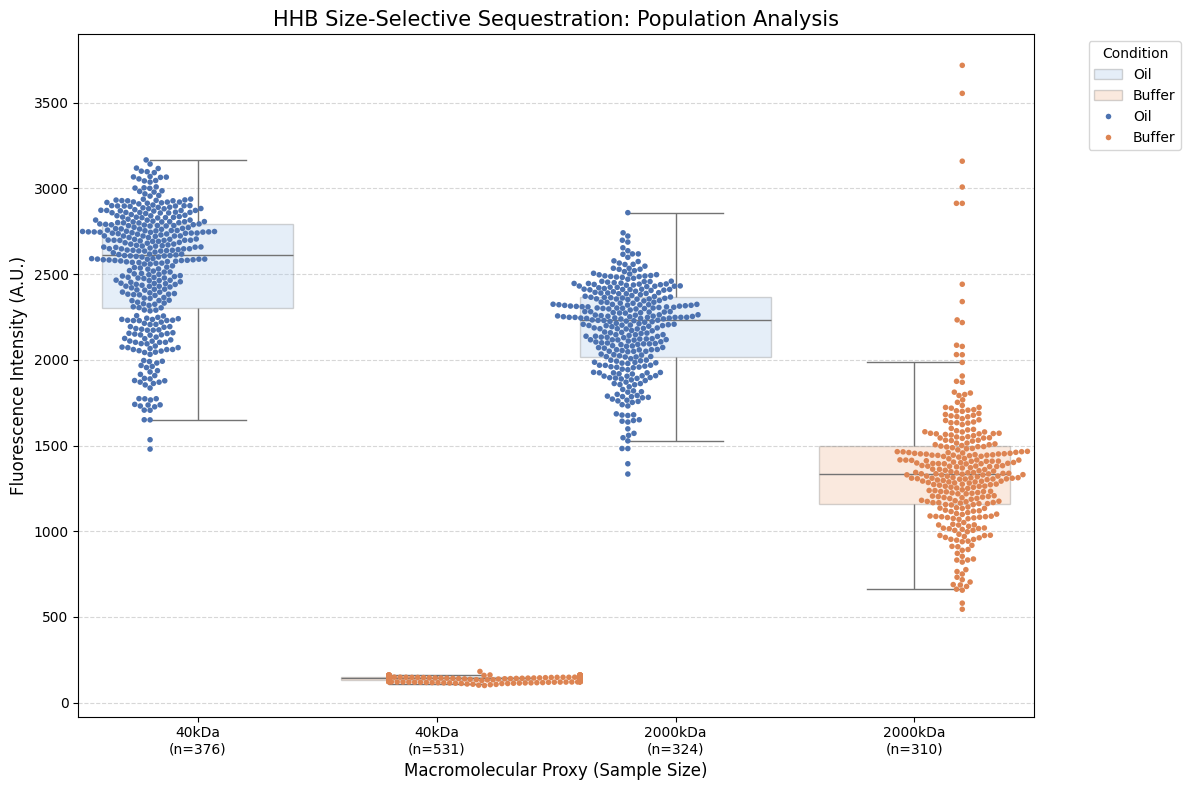

Figure saved to: /content/drive/MyDrive/849/Capture_Test/HHB_swarm_Plot.png


In [ ]:
# 2. CALCULATE RETENTION % AND SAMPLE SIZES (n)
def get_stats(df_oil, df_buf, name):
    n_oil = len(df_oil)
    n_buf = len(df_buf)
    mean_oil = df_oil['Intensity'].mean()
    mean_buf = df_buf['Intensity'].mean()
    retention = (mean_buf / mean_oil) * 100
    print(f"--- {name} Stats ---")
    print(f"Sample Size: Oil (n={n_oil}), Buffer (n={n_buf})")
    print(f"Retention: {retention:.2f}%\n")
    return n_oil, n_buf, retention

n40o, n40b, ret40 = get_stats(df40_oil, df40_buf, "40kDa")
n2000o, n2000b, ret2000 = get_stats(df2000_oil, df2000_buf, "2000kDa")

# 3. COMBINE FOR PLOTTING
# We add a label for the X-axis that includes the 'n' number
df40_oil['Label'] = f'40kDa\n(n={n40o})'
df40_buf['Label'] = f'40kDa\n(n={n40b})'
df2000_oil['Label'] = f'2000kDa\n(n={n2000o})'
df2000_buf['Label'] = f'2000kDa\n(n={n2000b})'

all_data = pd.concat([df40_oil, df40_buf, df2000_oil, df2000_buf])

# 4. CREATE THE DEFENSE PLOT
plt.figure(figsize=(12, 8))

# Draw a Boxplot for the summary background
sns.boxplot(data=all_data, x='Label', y='Intensity', hue='State',
            palette='pastel', showfliers=False, boxprops=dict(alpha=.3))

# Overlay the Swarmplot for the raw data "Proof"
sns.swarmplot(data=all_data, x='Label', y='Intensity', hue='State',
              dodge=True, size=4, palette='deep')

# Annotate Retention % on the plot
# plt.text(0, all_data['Intensity'].max()*0.9, f"Retention: {ret40:.1f}%", ha='center', fontweight='bold')
# plt.text(1, all_data['Intensity'].max()*0.9, f"Retention: {ret2000:.1f}%", ha='center', fontweight='bold')

plt.title('HHB Size-Selective Sequestration: Population Analysis', fontsize=15)
plt.ylabel('Fluorescence Intensity (A.U.)', fontsize=12)
plt.xlabel('Macromolecular Proxy (Sample Size)', fontsize=12)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
save_path = '/content/drive/MyDrive/849/Capture_Test/HHB_swarm_Plot.png'

plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved to: {save_path}")

# **Stripplot**

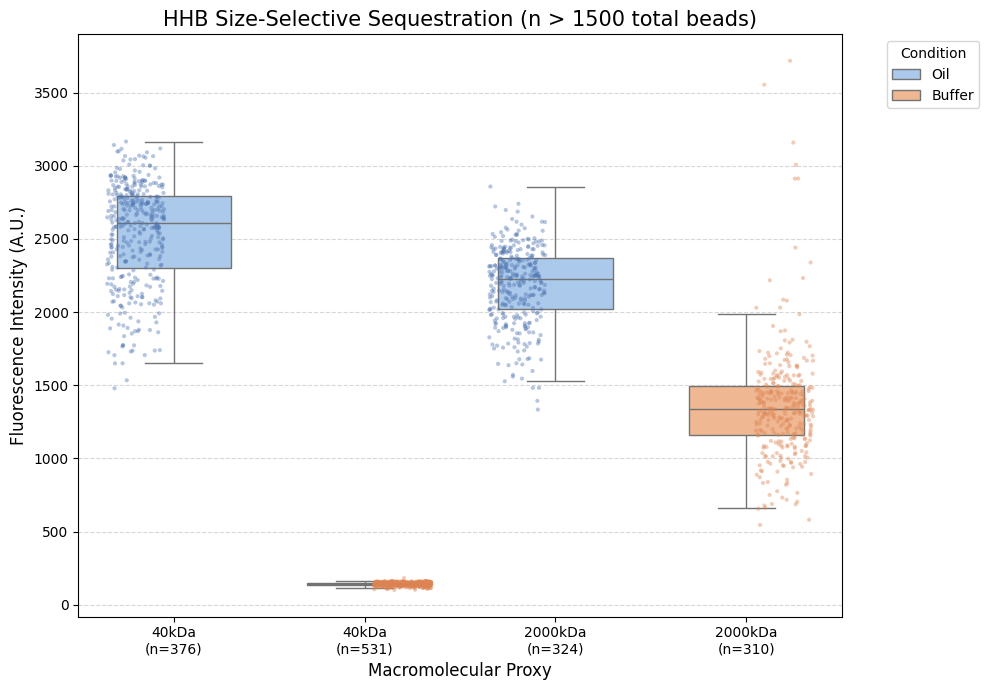

Figure saved to: /content/drive/MyDrive/849/Capture_Test/HHB_strip_Plot.png


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- (Keep your data loading part the same) ---

plt.figure(figsize=(10, 7))

# 1. Boxplot for the summary (Show the Mean and Quartiles)
# We set 'width' and 'dodge=True' to ensure alignment
sns.boxplot(data=all_data, x='Label', y='Intensity', hue='State',
            palette='pastel', showfliers=False, width=0.6)

# 2. Stripplot instead of Swarmplot (Handles n=500 much better)
# jitter=0.2 spreads the dots slightly so they aren't in a single line
# alpha=0.4 makes the dots semi-transparent so you can see where they are densest
sns.stripplot(data=all_data, x='Label', y='Intensity', hue='State',
              dodge=True, size=3, palette='deep', alpha=0.4, jitter=0.3)

# 3. Clean up the legend (remove the duplicate entries from box and strip)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Annotations
# plt.text(0, all_data['Intensity'].max()*0.85, f"Retention: {ret40:.1f}%", ha='center', color='black', fontweight='bold')
# plt.text(1, all_data['Intensity'].max()*0.85, f"Retention: {ret2000:.1f}%", ha='center', color='black', fontweight='bold')

plt.title('HHB Size-Selective Sequestration (n > 1500 total beads)', fontsize=15)
plt.ylabel('Fluorescence Intensity (A.U.)', fontsize=12)
plt.xlabel('Macromolecular Proxy', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
save_path = '/content/drive/MyDrive/849/Capture_Test/HHB_strip_Plot.png'

plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved to: {save_path}")

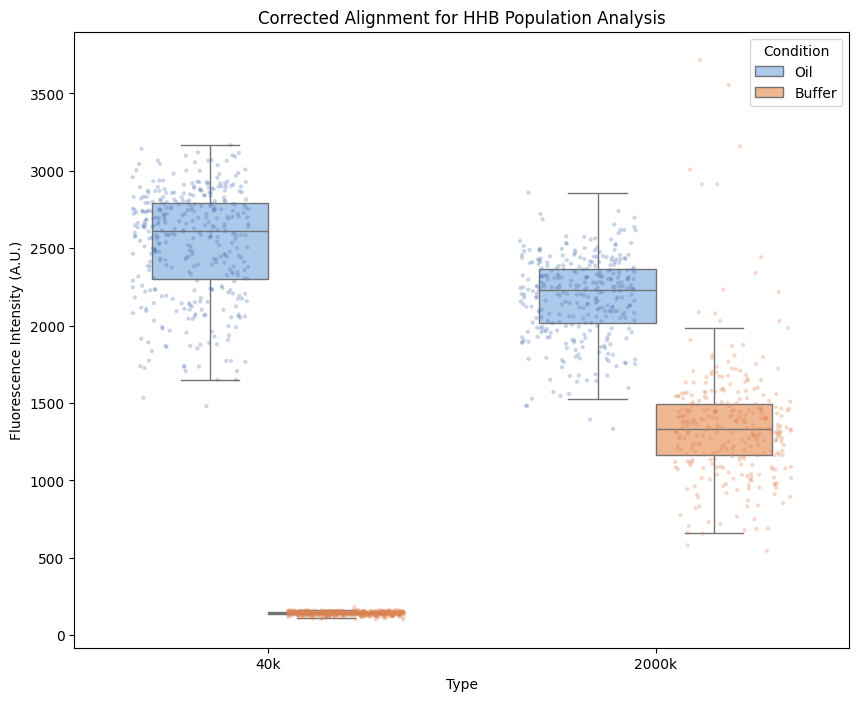

In [ ]:
# 1. Force the categories to be categorical types to prevent coordinate shifting
all_data['Type'] = pd.Categorical(all_data['Type'], categories=['40k', '2000k'])
all_data['State'] = pd.Categorical(all_data['State'], categories=['Oil', 'Buffer'])

plt.figure(figsize=(10, 8))

# 2. Plot the Boxplot first
# We use a specific width (0.6)
ax = sns.boxplot(data=all_data,
                 x='Type',
                 y='Intensity',
                 hue='State',
                 palette='pastel',
                 showfliers=False,
                 width=0.6,
                 dodge=True)

# 3. Plot the Stripplot
# THE TRICK: We use "dodge=True" and "jitter=True"
# but we explicitly tell it to use the same hue logic as the boxplot.
sns.stripplot(data=all_data,
              x='Type',
              y='Intensity',
              hue='State',
              palette='deep',
              size=3,
              alpha=0.3,
              jitter=0.3,
              dodge=True,
              ax=ax) # This forces it onto the same axes/coordinate system

# 4. REMOVE DUPLICATE LEGEND
# Because we called hue twice, we get two legends. This keeps only one.
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:2], labels[0:2], title='Condition')

# 5. ANNOTATIONS
y_max = all_data['Intensity'].max()
# plt.text(0, y_max * 1.05, f"40k Retention: {ret40:.1f}%", ha='center', weight='bold')
# plt.text(1, y_max * 1.05, f"2000k Retention: {ret2000:.1f}%", ha='center', weight='bold')

plt.ylabel('Fluorescence Intensity (A.U.)')
plt.title('Corrected Alignment for HHB Population Analysis')
plt.show()

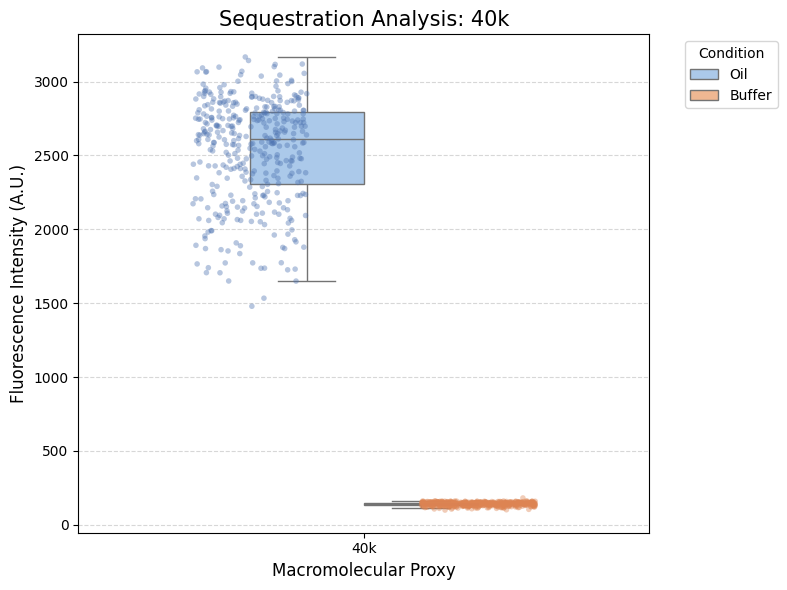

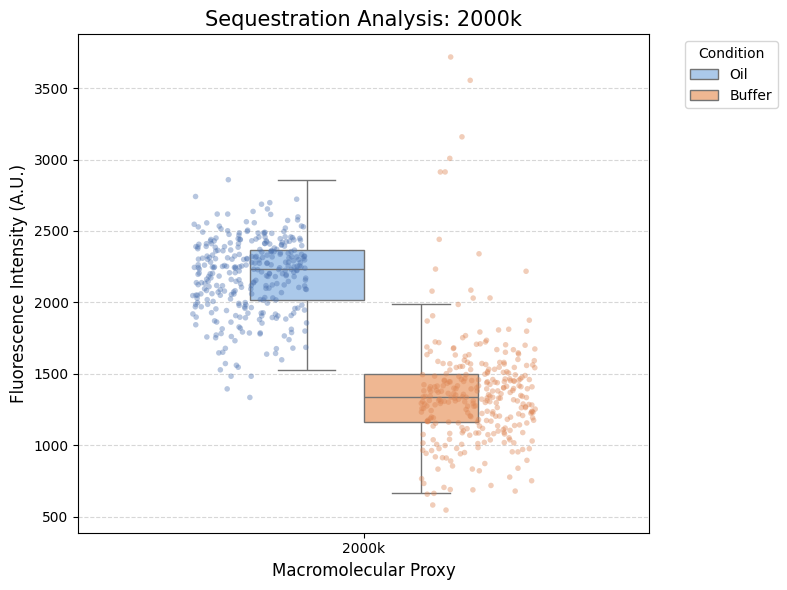

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Combine them
all_data = pd.concat([df40_oil, df40_buf, df2000_oil, df2000_buf])

# --- (Keep your data loading part the same) ---

# Get the unique types (e.g., ['40k', '2000k'])
unique_types = all_data['Type'].unique()

for t_value in unique_types:
    # Filter data for this specific type
    subset = all_data[all_data['Type'] == t_value]

    plt.figure(figsize=(8, 6))

    # 1. Layer the Boxplot
    sns.boxplot(data=subset, x='Type', y='Intensity', hue='State',
                palette='pastel', showfliers=False, width=0.4)

    # 2. Layer the Stripplot on top
    sns.stripplot(data=subset, x='Type', y='Intensity', hue='State',
                  dodge=True, size=4, palette='deep', alpha=0.4, jitter=0.2)

    # 3. Clean up the legend (remove duplicates)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[0:2], labels[0:2], title='Condition',
               bbox_to_anchor=(1.05, 1), loc='upper left')

    # Formatting
    plt.title(f'Sequestration Analysis: {t_value}', fontsize=15)
    plt.ylabel('Fluorescence Intensity (A.U.)', fontsize=12)
    plt.xlabel('Macromolecular Proxy', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show() # Shows each figure one after the other

/tmp/ipython-input-501472014.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='State', y='Intensity',
/tmp/ipython-input-501472014.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=subset, x='State', y='Intensity',
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 76.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 76.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


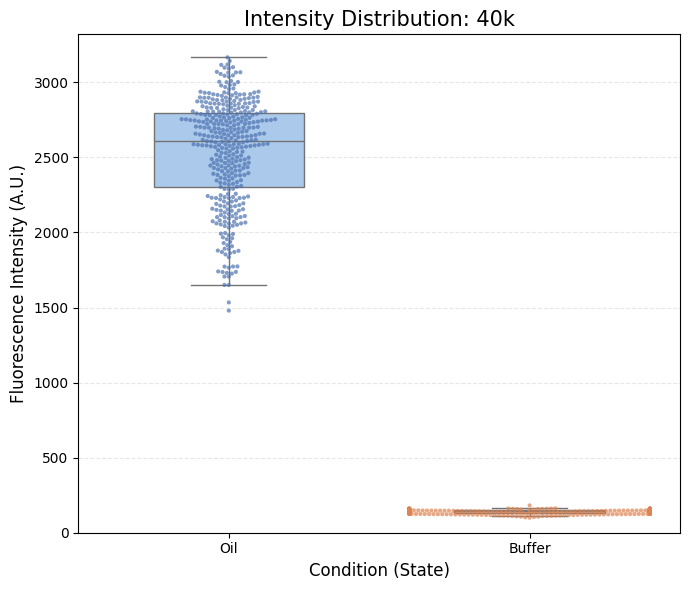

/tmp/ipython-input-501472014.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='State', y='Intensity',
/tmp/ipython-input-501472014.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=subset, x='State', y='Intensity',


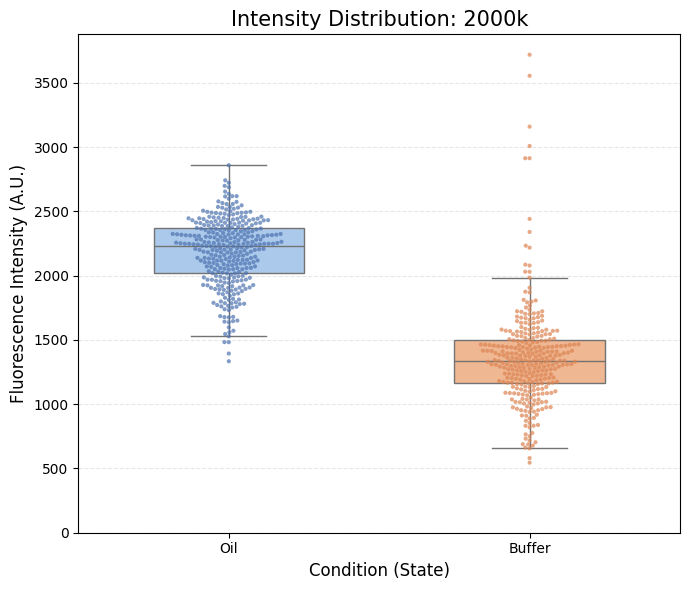

In [16]:
# Get the unique types (e.g., ['40k', '2000k'])
# If your column is 'Label', change 'Type' to 'Label' below
unique_types = all_data['Type'].unique()

for t_value in unique_types:
    # Filter data for this specific size (e.g., only 40k)
    subset = all_data[all_data['Type'] == t_value]

    plt.figure(figsize=(7, 6))

    # 1. Boxplot: We put 'State' on the X-axis now
    sns.boxplot(data=subset, x='State', y='Intensity',
                palette='pastel', showfliers=False, width=0.5)

    # 2. Swarmplot: Layered on top of the boxplot
    # Swarmplot positions dots so they don't overlap
    sns.swarmplot(data=subset, x='State', y='Intensity',
                  size=3, palette='deep', alpha=0.7)

    # 3. Formatting
    plt.title(f'Intensity Distribution: {t_value}', fontsize=15)
    plt.ylabel('Fluorescence Intensity (A.U.)', fontsize=12)
    plt.xlabel('Condition (State)', fontsize=12)
    plt.ylim(bottom=0)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # No legend needed since 'State' is now on the X-axis labels

    plt.tight_layout()
    plt.show() # Shows figure for this type, then moves to the next